# 3. Model evaluation 

Did our fine tuning actually improve the model's performance on our RAG task? Let's find out!

In order to measure the efficacy of RAFT, we'll compare a base gpt-4o-mini model with our fine tuned model.
In the first notebook, we generated a test set that's never been used to train the model, we will use the test set to compare our 2 models.

We will go through the following steps:
1. Load the test set
2. Perform inference with both models on the test set
3. Clean up the models answers to remove the Chain of Thought and only keep the final answer
3. Define evaluation metrics
4. Run evaluation for both models
5. Plot results


#### 1. Loading the test set

In [1]:
import pandas as pd

test_df = pd.read_json('/home/vhoudebine/projects/raft/data/training_data/banking_test.jsonl', lines=True)
test_df.head(2)

,id,type,question,context,oracle_context,cot_answer,instruction,messages
0,seed_task_109,general,How soon should you notify BMO if your debit c...,{'sentences': [['--- #### epost™ View and pay...,### TeleTypewriter (TTY) line\nBMO Bank of Mon...,To answer the question about how soon you shou...,<DOCUMENT>---\n\n#### epost™\nView and pay you...,"[{'role': 'user', 'content': '<DOCUMENT>--- #..."
1,seed_task_69,general,Is there a fee for using the Overdraft Transfe...,{'sentences': [['In addition to completing you...,| **Added protection** | ...,To determine if there is a fee for using the O...,<DOCUMENT>In addition to completing your day-t...,"[{'role': 'user', 'content': '<DOCUMENT>In add..."


#### 2. Run inference on the test set with both models

Make sure your `.env` file contains endpoint, api key and deployment name for the baseline model and the fine tuned model. Here we compare the fine tuned gpt-4o-mini with gpt-4o-mini base but you could switch the baseline model to any model

In [13]:
from dotenv import load_dotenv
import os
from openai import AzureOpenAI


load_dotenv()
# run the base and finetuned models through the dataset
BASELINE_OPENAI_DEPLOYMENT = os.getenv("BASELINE_OPENAI_DEPLOYMENT")
BASELINE_OPENAI_ENDPOINT= os.getenv("BASELINE_OPENAI_ENDPOINT")
BASELINE_OPENAI_KEY= os.getenv("BASELINE_OPENAI_KEY")

FINETUNED_OPENAI_DEPLOYMENT = os.getenv("FINETUNED_OPENAI_DEPLOYMENT")
FINETUNED_OPENAI_ENDPOINT = os.getenv("FINETUNED_OPENAI_ENDPOINT")
FINETUNED_OPENAI_KEY = os.getenv("FINETUNED_OPENAI_KEY")

baseline_client = AzureOpenAI(
    azure_endpoint=BASELINE_OPENAI_ENDPOINT, 
    api_key=BASELINE_OPENAI_KEY,
    api_version="2024-02-01"
    )

finetuned_client = AzureOpenAI(
    azure_endpoint=FINETUNED_OPENAI_ENDPOINT, 
    api_key=FINETUNED_OPENAI_KEY,
    api_version="2024-02-01"

    )

# get the predictions
def get_model_completions(client, prompt, deployment):
    """
    This function generates a model completion from a given prompt using the OpenAI API.

    Parameters:
    client (openai.Client): The AzureOpenAI client being used.
    prompt (str): The prompt to be sent to the model for completion.
    deployment (str): The identifier of the model deployment to be used for completion.

    Returns:
    str: The completed message content from the model. If an exception occurs during the process, it returns None and prints the exception.
    """


    messages = [
        {'role':'user','content':prompt}
        ]
    try:
        response = client.chat.completions.create(
        messages=messages,
        model=deployment,
        temperature=0.3,
    )
    
        return response.choices[0].message.content

    except Exception as e:
        print(e)
        return None
    


In [15]:

from tqdm.notebook import tqdm

tqdm.pandas()

test_df['baseline_model_response'] = test_df.progress_apply(lambda x: get_model_completions(baseline_client, x.instruction, BASELINE_OPENAI_DEPLOYMENT), axis=1)
test_df['finetuned_model_response'] = test_df.progress_apply(lambda x: get_model_completions(finetuned_client, x.instruction, FINETUNED_OPENAI_DEPLOYMENT), axis=1)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

#### 3. Clean up the model answers

Because our fine tuned model has been trained with Chain of Thought answers, we need to clean up the answers to extract the final answer and match the format of the baseline model answers.

Similarly, to run evaluation on RAG, we'll need to extract a clean context string with the content of the retrieved documents

In [16]:
def extract_final_answer(cot_answer: str) -> str:
    """
    Extracts the final answer from the cot_answer field
    """
    if cot_answer:
        return cot_answer.split("<ANSWER>: ")[-1]
    return None

def extract_context(instruction: str) -> str:
    """
    Extracts the context from the instruction field.
    Keeps all <DOCUMENTS/> and removes the last line with the question.
    """
    return "\n".join(instruction.split("\n")[:-1])

test_df['gold_final_answer'] = test_df.cot_answer.apply(extract_final_answer)
test_df.rename(columns={'context':'context_docs'}, inplace=True)
test_df['context'] = test_df.instruction.apply(extract_context)
test_df['baseline_final_answer'] = test_df.baseline_model_response.apply(extract_final_answer)
test_df['finetuned_final_answer'] = test_df.finetuned_model_response.apply(extract_final_answer)


In [26]:
test_df.head(2)

,id,type,question,context_docs,oracle_context,cot_answer,instruction,messages,baseline_model_response,finetuned_model_response,gold_final_answer,context_docs,baseline_final_answer,finetuned_final_answer,context
0,seed_task_109,general,How soon should you notify BMO if your debit c...,{'sentences': [['--- #### epost™ View and pay...,### TeleTypewriter (TTY) line\nBMO Bank of Mon...,To answer the question about how soon you shou...,<DOCUMENT>---\n\n#### epost™\nView and pay you...,"[{'role': 'user', 'content': '<DOCUMENT>--- #...","You should notify BMO as soon as possible, wit...","To answer the question ""How soon should you no...","You should notify BMO as soon as possible, ide...",<DOCUMENT>---\n\n#### epost™\nView and pay you...,"You should notify BMO as soon as possible, wit...","You should notify BMO as soon as possible, and...",<DOCUMENT>---\n\n#### epost™\nView and pay you...
1,seed_task_69,general,Is there a fee for using the Overdraft Transfe...,{'sentences': [['In addition to completing you...,| **Added protection** | ...,To determine if there is a fee for using the O...,<DOCUMENT>In addition to completing your day-t...,"[{'role': 'user', 'content': '<DOCUMENT>In add...","No, there is no extra charge for using the Ove...",To determine if there is a fee for using the O...,"No, there is no fee for using the Overdraft Tr...",<DOCUMENT>In addition to completing your day-t...,"No, there is no extra charge for using the Ove...","No, there is no fee for using the Overdraft Tr...",<DOCUMENT>In addition to completing your day-t...


#### 4. Define evaluation metrics

We'll use RAGAS to evaluate the performance of the models on this RAG task. Ragas is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines. Ragas offers metrics tailored for evaluating each component of your RAG pipeline.

For the scope of this workshop, we are only interested in evaluation the generation part of the pipeline.

Ragas provides a few out of the box metrics we can compute, these metrics require either an LLM as a judge or an embedding model:
- Answer relevancy: assesses how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy
- Faithfulness: This measures the factual consistency of the generated answer against the given context
- Answer similarity: semantic resemblance between the generated answer and the ground truth.
- Answer correctness: Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score

In [18]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    answer_similarity,
    answer_correctness
)
from ragas.metrics.critique import harmfulness

# list of metrics we're going to use
metrics = [
    faithfulness,
    answer_relevancy,
    answer_similarity,
    answer_correctness
]

In [19]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate
from dotenv import load_dotenv
import os

load_dotenv()

judge_model_endpoint = os.getenv("JUDGE_OPENAI_ENDPOINT")
judge_model_api_key = os.getenv("JUDGE_OPENAI_API_KEY")
judge_model_deployment = os.getenv("JUDGE_OPENAI_DEPLOYMENT")
embedding_model_deployment= os.getenv("EMBEDDING_OPENAI_DEPLOYMENT")

azure_model = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_endpoint=judge_model_endpoint,
    azure_deployment=judge_model_deployment,
    validate_base_url=False,
    api_key=judge_model_api_key,
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=judge_model_endpoint,
    azure_deployment=embedding_model_deployment,
    api_key=judge_model_api_key,
)

In [20]:
from datasets import Dataset

baseline_df = test_df[['baseline_final_answer',
                      'context',
                      'gold_final_answer',
                      'question']]

baseline_df.rename(columns={'baseline_final_answer':'answer', 
                            'gold_final_answer':'ground_truth',
                            'context':'contexts'}, inplace=True)
#baseline_df['ground_truth'] = baseline_df['ground_truth'].apply(lambda x: [x] if x else [])
baseline_df['contexts'] = baseline_df['contexts'].apply(lambda x: [x] if x else [])

dataset = Dataset.from_pandas(baseline_df)


/tmp/ipykernel_330565/3249423093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df.rename(columns={'baseline_final_answer':'answer',
/tmp/ipykernel_330565/3249423093.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['contexts'] = baseline_df['contexts'].apply(lambda x: [x] if x else [])


#### 5. Computing the evaluation metrics for both models

In [21]:
baseline_result = evaluate(
    dataset, metrics=metrics, llm=azure_model, embeddings=azure_embeddings
)

baseline_result

Evaluating:   0%|          | 0/212 [00:00<?, ?it/s]

{'faithfulness': 0.7479, 'answer_relevancy': 0.8172, 'answer_similarity': 0.9122, 'answer_correctness': 0.5927}

In [22]:
finetuned_df = test_df[['finetuned_final_answer',
                      'context',
                      'gold_final_answer',
                      'question']]

finetuned_df.rename(columns={'finetuned_final_answer':'answer', 
                            'gold_final_answer':'ground_truth',
                            'context':'contexts'}, inplace=True)
#baseline_df['ground_truth'] = baseline_df['ground_truth'].apply(lambda x: [x] if x else [])
finetuned_df['contexts'] = finetuned_df['contexts'].apply(lambda x: [x] if x else [])

ft_dataset = Dataset.from_pandas(finetuned_df)

ft_result = evaluate(
    ft_dataset, metrics=metrics, llm=azure_model, embeddings=azure_embeddings
)

ft_result

/tmp/ipykernel_330565/2188515160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df.rename(columns={'finetuned_final_answer':'answer',
/tmp/ipykernel_330565/2188515160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df['contexts'] = finetuned_df['contexts'].apply(lambda x: [x] if x else [])


Evaluating:   0%|          | 0/212 [00:00<?, ?it/s]

No statements were generated from the answer.


{'faithfulness': 0.5991, 'answer_relevancy': 0.9776, 'answer_similarity': 0.9485, 'answer_correctness': 0.6503}

In [23]:

baseline_dict = dict(baseline_result)
ft_dict = dict(ft_result)

ft_dict['model']=os.getenv("FINETUNED_OPENAI_DEPLOYMENT")
baseline_dict['model']=os.getenv("BASELINE_OPENAI_DEPLOYMENT")

results_df = pd.DataFrame([baseline_dict, ft_dict])

#### 6. Plotting the side-by-side comparison of the models

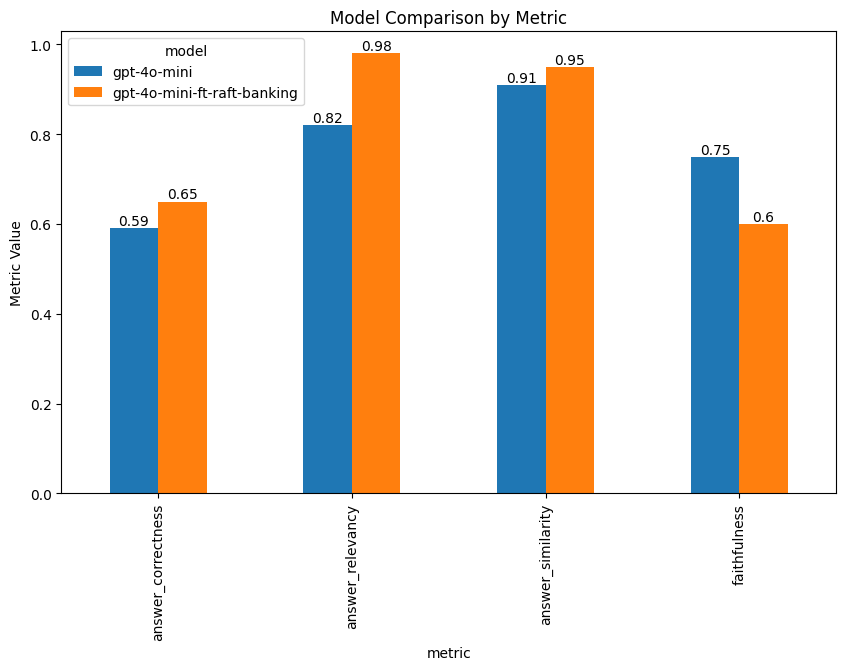

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your results_df DataFrame

# Reshape the DataFrame
melted_df = results_df.melt(id_vars='model', var_name='metric', value_name='value')
melted_df['value'] = melted_df['value'].round(2)

# Create the bar plot
pivoted_data = melted_df.pivot_table(index='metric', columns='model', values='value')
ax = pivoted_data.plot(kind='bar', figsize=(10, 6))

# Add value labels on top of the bars
for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('Metric Value')
plt.title('Model Comparison by Metric')
plt.show()